# Feature Engineer

In [194]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import MinMaxScaler


from collections import namedtuple, defaultdict

In [195]:
zip = zipfile.ZipFile('../data/archive.zip')
fp = zip.open('Historical Product Demand.csv') 
df = pd.read_csv(fp)


df.dropna(subset=['Date'], inplace=True)
df.dropna(subset=['Order_Demand'], inplace=True)

df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")
df['Order_Demand'] = df['Order_Demand'].astype('int64')

df['Date'] = pd.to_datetime(df['Date']) 
df.sort_values('Date', inplace=True)

df['Month']  = df['Date'].dt.month_name()
df['Year']   = df['Date'].dt.year
df['Months'] = df['Date'].dt.to_period('M').dt.to_timestamp()

In [196]:
df_whse_a = df[df.Warehouse == 'Whse_A']

In [197]:
n_products = len(set(df_whse_a['Product_Code']))
n_rows = len(df_whse_a)
n_warehouse = len(set(df_whse_a['Warehouse']))
n_categories = len(set(df_whse_a['Product_Category']))

print(f"""
#rows:       {n_rows}
#products:   {n_products}
#categories: {n_categories}
#warehouse:  {n_warehouse}
""")


#rows:       142335
#products:   427
#categories: 25
#warehouse:  1



In [198]:
x = df_whse_a[(df_whse_a.Months >= '2012-01-01') & (df_whse_a.Months < '2017-01-01')].groupby('Months')['Order_Demand'].sum()
x = x.reset_index()

In [199]:
# choose a warehouse
df_whse_a.drop(['Warehouse', 'Product_Category'], axis=1, inplace=True)

/tmp/ipykernel_77474/3432016049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_whse_a.drop(['Warehouse', 'Product_Category'], axis=1, inplace=True)


In [200]:
# filter for freuent product
threshold = 1000
filtered_data = df_whse_a[(df_whse_a.Year >= 2012) & (df_whse_a.Year < 2017)]
frequent_products = filtered_data['Product_Code'].value_counts()[filtered_data['Product_Code'].value_counts() > threshold].index
filtered_data = filtered_data[filtered_data.Product_Code.isin(frequent_products)]

In [201]:
# aggregation
data_aggregated       = filtered_data[['Product_Code', 'Date', 'Order_Demand']]
data_aggregated       = data_aggregated.groupby(['Product_Code', 'Date']).sum().reset_index()

# weekly
data_pivot            = data_aggregated.pivot(index='Date', columns='Product_Code', values='Order_Demand').fillna(0)
data_resampled_weekly = data_pivot.resample('W').sum()

# daily
daily_index           = pd.date_range(start=data_resampled_weekly.index.min(), end=data_resampled_weekly.index.max(), freq='D')
data_resampled_daily  = data_resampled_weekly.reindex(daily_index).ffill() / 7

In [202]:
import numpy as np
from numpy.fft import fft

def spectrogram(audio, win = 7, step=1, normalize=True):
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        dft = np.abs(fft(audio[i - win: i] * hanning))
        if normalize:
            mu  = np.mean(dft)
            std = np.std(dft) + 1.0
            spectrogram.append((dft - mu) / std)
        else:
            spectrogram.append(dft)        
    spectrogram = np.array(spectrogram)[:, :win//2]
    return spectrogram

In [203]:
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

WEEK_IDX = {
  'Monday' : 0,
  'Tuesday': 1,
  'Wednesday': 2,
  'Thursday': 3,
  'Friday':4 ,
  'Saturday': 5,
  'Sunday': 6, 
}
def days_of_week(df, time_steps=1): 
    names = list(df.index.day_name())
    names = [WEEK_IDX[name] for name in names]
    X = []
    for i in range(len(names) - time_steps):
        X.append(names[i:(i + time_steps)])
    return np.array(X)


MONTH_IDX = {
    'January': 0,
    'February': 1,
    'March': 2,
    'April': 3,
    'May': 4,
    'June': 5,
    'July': 6,
    'August': 7,
    'September': 8,
    'October': 9,
    'November': 10,
    'December': 11
}
def month_of_year(df, time_steps=1): 
    names = list(df.index.month_name())
    names = [MONTH_IDX[name] for name in names]
    X = []
    for i in range(len(names) - time_steps):
        X.append(names[i:(i + time_steps)])
    return np.array(X)


def spectrogram_features(data, time_steps=1):
    t, d = data.shape
    spectrograms = []
    for i in range(0, d):
        spectrograms.append(spectrogram(data[:, i], win=30).T)
    stacked = np.stack(spectrograms).T
    X = []
    for i in range(len(stacked) - time_steps):
        X.append(stacked[i:(i + time_steps)])
    return np.array(X)


def dft_at_label(data):
    t, d = data.shape
    spectrograms = []
    for i in range(0, d):
        spectrograms.append(spectrogram(data[:, i], win=30).T)
    stacked = np.stack(spectrograms).T
    X = []
    for i in range(len(stacked) - time_steps):
        X.append(stacked[i + time_steps - 1])
    return np.array(X)

def day_at_label(df):
    names = list(df.index.day_name())
    names = [WEEK_IDX[name] for name in names]
    X = []
    for i in range(len(names) - time_steps):
        X.append(names[i + time_steps])
    return np.array(X)

def month_at_label(df):
    names = list(df.index.month_name())
    names = [MONTH_IDX[name] for name in names]
    X = []
    for i in range(len(names) - time_steps):
        X.append(names[i + time_steps])
    return np.array(X)



In [204]:
data_resampled_daily

Product_Code,Product_0123,Product_0200,Product_0202,Product_0206,Product_0211,Product_0349,Product_0979,Product_0982,Product_0984,Product_1250,...,Product_1424,Product_1461,Product_1464,Product_1470,Product_1496,Product_1513,Product_1539,Product_1541,Product_1548,Product_1669
2012-01-08,191.428571,101.142857,77.000000,150.000000,81.571429,11.285714,357.142857,0.000000,571.428571,528.571429,...,300.000000,1364.285714,71.428571,2314.285714,1628.571429,3328.571429,757.142857,300.0,192.857143,11.428571
2012-01-09,191.428571,101.142857,77.000000,150.000000,81.571429,11.285714,357.142857,0.000000,571.428571,528.571429,...,300.000000,1364.285714,71.428571,2314.285714,1628.571429,3328.571429,757.142857,300.0,192.857143,11.428571
2012-01-10,191.428571,101.142857,77.000000,150.000000,81.571429,11.285714,357.142857,0.000000,571.428571,528.571429,...,300.000000,1364.285714,71.428571,2314.285714,1628.571429,3328.571429,757.142857,300.0,192.857143,11.428571
2012-01-11,191.428571,101.142857,77.000000,150.000000,81.571429,11.285714,357.142857,0.000000,571.428571,528.571429,...,300.000000,1364.285714,71.428571,2314.285714,1628.571429,3328.571429,757.142857,300.0,192.857143,11.428571
2012-01-12,191.428571,101.142857,77.000000,150.000000,81.571429,11.285714,357.142857,0.000000,571.428571,528.571429,...,300.000000,1364.285714,71.428571,2314.285714,1628.571429,3328.571429,757.142857,300.0,192.857143,11.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,134.285714,157.142857,101.428571,41.428571,0.000000,35.428571,171.428571,285.714286,285.714286,585.714286,...,914.285714,357.142857,0.000000,8557.142857,5492.857143,900.000000,35.714286,0.0,4450.000000,88.571429
2016-12-29,134.285714,157.142857,101.428571,41.428571,0.000000,35.428571,171.428571,285.714286,285.714286,585.714286,...,914.285714,357.142857,0.000000,8557.142857,5492.857143,900.000000,35.714286,0.0,4450.000000,88.571429
2016-12-30,134.285714,157.142857,101.428571,41.428571,0.000000,35.428571,171.428571,285.714286,285.714286,585.714286,...,914.285714,357.142857,0.000000,8557.142857,5492.857143,900.000000,35.714286,0.0,4450.000000,88.571429
2016-12-31,134.285714,157.142857,101.428571,41.428571,0.000000,35.428571,171.428571,285.714286,285.714286,585.714286,...,914.285714,357.142857,0.000000,8557.142857,5492.857143,900.000000,35.714286,0.0,4450.000000,88.571429


In [205]:
train = data_resampled_daily[data_resampled_daily.index < '2016-01-01']
test = data_resampled_daily[data_resampled_daily.index >= '2016-01-01']

In [206]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [381]:
T = 30

In [382]:
spec = spectrogram_features(scaled_data, time_steps=T)

In [383]:
month_features = month_of_year(train, time_steps=T)

In [384]:
day_features = days_of_week(train, time_steps=T)

In [385]:
time_steps = T  # e.g., 30 days
X, y = create_sequences(scaled_data, time_steps)

In [386]:
dft = dft_at_label(scaled_data)

In [387]:
day = day_at_label(train)

In [388]:
month  = month_at_label(train)

In [408]:
X.shape, y.shape, month_features.shape, day_features.shape, spec.shape, dft.shape, day.shape, month.shape

((1424, 30, 31),
 (1424, 31),
 (1424, 30),
 (1424, 30),
 (1394, 30, 15, 31),
 (1394, 15, 31),
 (1424,),
 (1424,))

In [409]:
import pickle as pkl

Features = namedtuple('Features', 'seq months days spec lab dft day month')

with open('features.pkl', 'wb') as f:
    pkl.dump(Features(X, month_features, day_features, spec, y, dft, day, month), f)

with open('scaler.pkl', 'wb') as f:
    pkl.dump(scaler, f)

with open('scaled_test.pkl', 'wb') as f:
    pkl.dump(scaled_test, f)

# Modeling

In [3]:
import pickle as pkl
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import * 
from tensorflow.keras.models import * 
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import * 
from tensorflow.keras.metrics import * 
Features = namedtuple('Features', 'seq months days spec lab dft day month')

In [4]:
features = pkl.load(open('features.pkl', 'rb'))

## Base Model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(features.seq, features.lab, test_size=0.1)
print(X_train.shape, y_train.shape)

(1281, 30, 31) (1281, 31)


In [29]:
def predictor():
    i = Input((30, 31))
    x = LSTM(31, activation='relu', dropout=0.2)(i)
    return Model(inputs=[i], outputs=[x])

model = predictor()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 31)             │         7,812 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,812 (30.52 KB)

 Trainable params: 7,812 (30.52 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
opt = Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0332 - root_mean_squared_error: 0.1816 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - root_mean_squared_error: 0.1369 - val_loss: 0.0154 - val_root_mean_squared_error: 0.1243
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0159 - root_mean_squared_error: 0.1261 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1120
Epoch 5/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0139 - root_mean_squared_error: 0.1181 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 6/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138 - root_mean_squared_error: 0.1176 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 7/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss:

In [31]:
features.day.shape, features.month.shape

((1424,), (1424,))

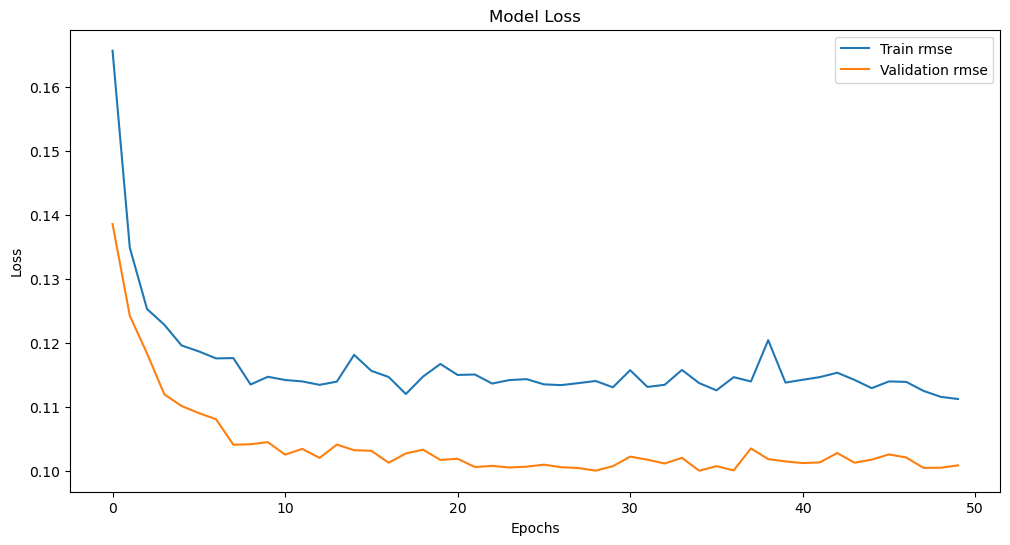

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [33]:
model.save('model_base.keras')

## Meta data at label

In [146]:
def predictor_meta():
    i_seq = Input((7, 31))
    x_seq = LSTM(64, activation='relu')(i_seq)

    i_month = Input((1,))
    i_day = Input((1,))
    e_month = CategoryEncoding(num_tokens=12)(i_month)
    e_day = CategoryEncoding(num_tokens=7)(i_day) 

    i_dft = Input((465,))
    
    i = Concatenate(axis = 1)([e_month, e_day, x_seq, i_dft])
    
    x = Dense(128, activation='relu')(i)
    x = Dropout(0.75)(x)
    x = Dense(31, activation='relu')(x)
    return Model(inputs=[i_seq, i_day, i_month, i_dft], outputs=[x])

model = predictor_meta()
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 7, 31)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding   │ (None, 12)        │          0 │ input_layer_6[0]… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_encoding_1 │ (None, 7)         │          0 │ input_layer_7[0]… │
│ (CategoryEncoding)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     24,576 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 465)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 548)       │          0 │ category_encodin… │
│ (Concatenate)       │                   │            │ category_encodin… │
│                     │                   │            │ lstm_5[0][0],     │
│                     │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     70,272 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 31)        │      3,999 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 98,847 (386.12 KB)

 Trainable params: 98,847 (386.12 KB)

 Non-trainable params: 0 (0.00 B)

In [147]:
n = len(features.dft)
X_train, X_test, y_train, y_test, X_day_train, X_day_test, X_month_train, X_month_test, X_dft_train, X_dft_test = train_test_split(features.seq[:n], features.lab[:n], features.day[:n], features.month[:n], features.dft, test_size=0.3)
X_dft_train = X_dft_train.reshape((len(X_dft_train), 15 * 31 ))
X_dft_test = X_dft_test.reshape((len(X_dft_test), 15 * 31 ))

print(X_train.shape, y_train.shape, X_day_train.shape, X_month_train.shape, X_dft_train.shape)

(991, 7, 31) (991, 31) (991,) (991,) (991, 465)


In [148]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, X_day_train, X_month_train, X_dft_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, X_day_test, X_month_test, X_dft_test], y_test), callbacks=[early_stopping])

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2300 - root_mean_squared_error: 0.4594 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2426
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0579 - root_mean_squared_error: 0.2407 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0560 - root_mean_squared_error: 0.2366 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0573 - root_mean_squared_error: 0.2394 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0578 - root_mean_squared_error: 0.2404 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437


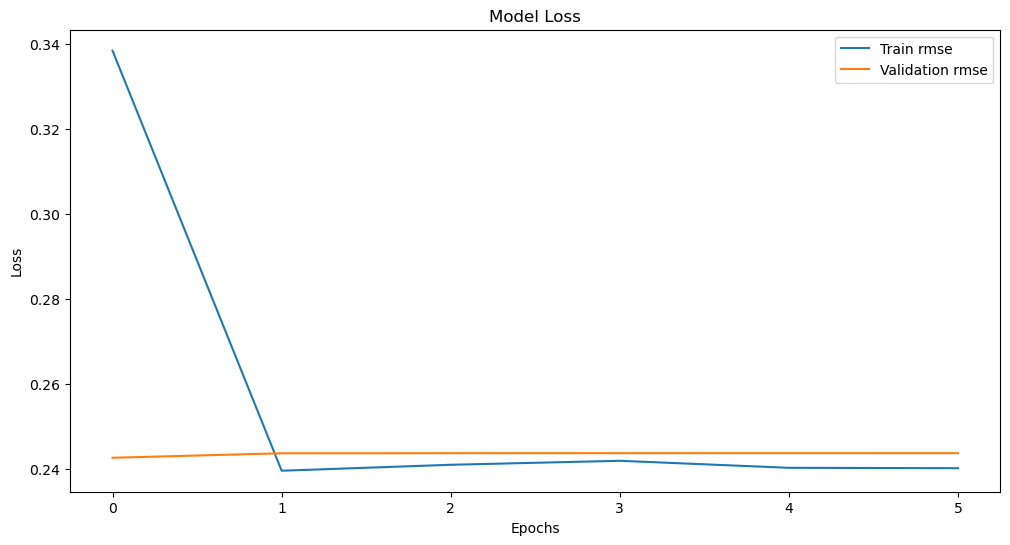

In [149]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Include Day of Week / Month of Year

### Learned Embedding

In [153]:
def predictor_v2():
    i_seq = Input((7, 31))
    i_month = Input((7,))
    i_day = Input((7,))
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day])
    
    
    x = LSTM(31, activation='relu', dropout=0.75)(i)
    return Model(inputs=[i_seq, i_day, i_month], outputs=[x])

model = predictor_v2()
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 7, 31)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 7, 12)     │        144 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 7, 7)      │         49 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 7, 50)     │          0 │ input_layer_12[0… │
│ (Concatenate)       │                   │            │ embedding_2[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 31)        │     10,168 │ concatenate_2[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,361 (40.47 KB)

 Trainable params: 10,361 (40.47 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test =\
train_test_split(features.seq, features.lab, features.days, features.months, test_size=0.3)

In [155]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test], y_test), callbacks=[early_stopping])

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0443 - root_mean_squared_error: 0.2101 - val_loss: 0.0258 - val_root_mean_squared_error: 0.1606
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274 - root_mean_squared_error: 0.1654 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1502
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0245 - root_mean_squared_error: 0.1564 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1486
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1482
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0242 - root_mean_squared_error: 0.1557 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1467
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0238 - root_mean_squared_error: 0.1541 - val_loss: 0.0216 - val_root_mean_squared_error: 0.1471
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.025

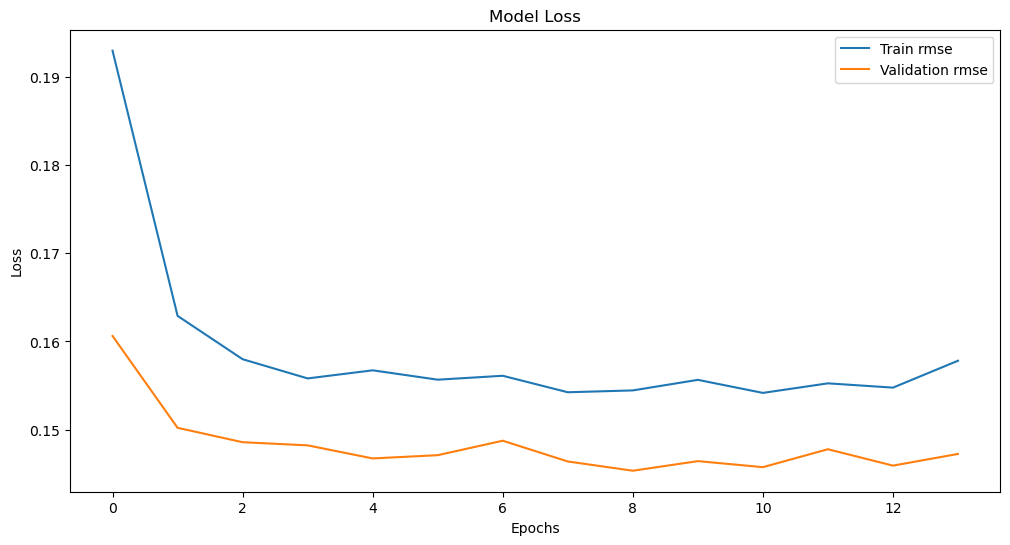

In [156]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### LSTM Stack

In [110]:
def predictor_v2_2():
    i_seq = Input((30, 31))
    i_month = Input((30, ))
    i_day = Input((30, ))
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day])
    
    
    x = LSTM(128, return_sequences=True)(i)
    x = LSTM(31, activation='relu', dropout=0.75)(x)
    return Model(inputs=[i_seq, i_day, i_month], outputs=[x])


model = predictor_v2_2()
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_48      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_49      │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_47      │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 30, 12)    │        144 │ input_layer_48[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 30, 7)     │         49 │ input_layer_49[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 30, 50)    │          0 │ input_layer_47[0… │
│ (Concatenate)       │                   │            │ embedding_2[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 30, 128)   │     91,648 │ concatenate_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_17 (LSTM)      │ (None, 31)        │     19,840 │ lstm_16[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 111,681 (436.25 KB)

 Trainable params: 111,681 (436.25 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test =\
train_test_split(features.seq, features.lab, features.days, features.months, test_size=0.3)

In [113]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test], y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 257.6339 - root_mean_squared_error: 15.1687 - val_loss: 0.2090 - val_root_mean_squared_error: 0.4571
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.7349 - root_mean_squared_error: 0.8543 - val_loss: 0.2049 - val_root_mean_squared_error: 0.4526
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.3920 - root_mean_squared_error: 0.6256 - val_loss: 0.1057 - val_root_mean_squared_error: 0.3252
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.3223 - root_mean_squared_error: 0.5673 - val_loss: 0.1139 - val_root_mean_squared_error: 0.3375
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.2958 - root_mean_squared_error: 0.5435 - val_loss: 0.0628 - val_root_mean_squared_error: 0.2506
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.2166 - root_mean_squared_error: 0.4653 - val_loss: 0.0718 - val_root_mean_squared_error: 0.2680
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - lo

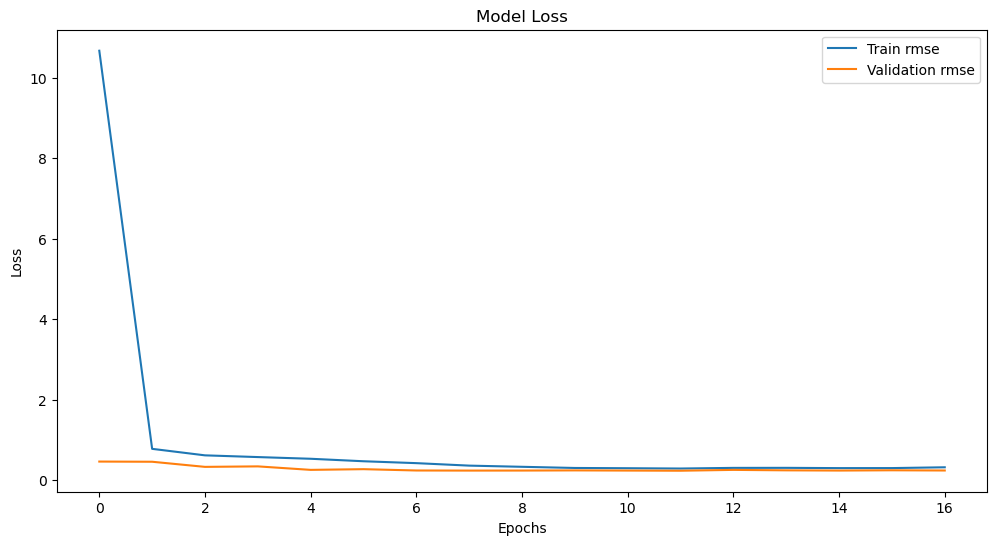

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Encoding

In [115]:
def predictor_v2_3():
    i_seq = Input((30, 31))
    i_month = Input((30, 1))
    i_day = Input((30, 1))
    
    e_month = TimeDistributed(CategoryEncoding(num_tokens=12))(i_month)
    e_day = TimeDistributed(CategoryEncoding(num_tokens=7))(i_day) 
    print(e_month.shape)
    i = Concatenate(axis = 2)([i_seq, e_month, e_day])
    
    x = LSTM(31, activation='relu', dropout=0.75)(i)
    return Model(inputs=[i_seq, i_day, i_month], outputs=[x])


model = predictor_v2_3()
model.summary()

(None, 30, 12)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_51      │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_52      │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_50      │ (None, 30, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 12)    │          0 │ input_layer_51[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 30, 7)     │          0 │ input_layer_52[0… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 30, 50)    │          0 │ input_layer_50[0… │
│ (Concatenate)       │                   │            │ time_distributed… │
│                     │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 31)        │     10,168 │ concatenate_11[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,168 (39.72 KB)

 Trainable params: 10,168 (39.72 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test =\
train_test_split(features.seq, features.lab, features.days, features.months, test_size=0.3)

In [118]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test], y_test), callbacks=[early_stopping])

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0442 - root_mean_squared_error: 0.2096 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0276 - root_mean_squared_error: 0.1662 - val_loss: 0.0237 - val_root_mean_squared_error: 0.1538
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0237 - root_mean_squared_error: 0.1540 - val_loss: 0.0226 - val_root_mean_squared_error: 0.1502
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0230 - root_mean_squared_error: 0.1517 - val_loss: 0.0206 - val_root_mean_squared_error: 0.1436
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0221 - root_mean_squared_error: 0.1485 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1454
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0217 - root_mean_squared_error: 0.1472 - val_loss: 0.0211 - val_root_mean_squared_error: 0.1453
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss:

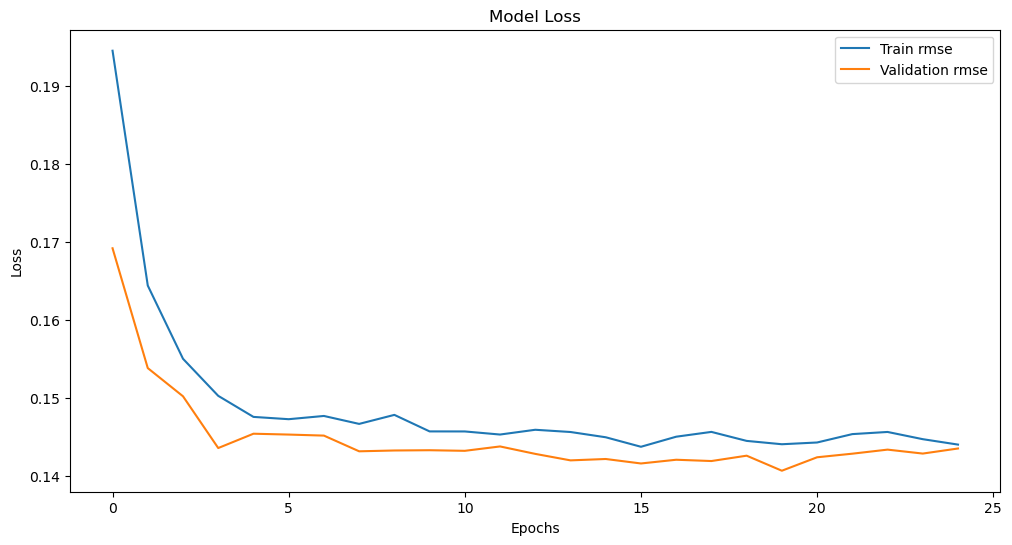

In [119]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Spectogram Features

In [217]:
features.spec.shape

(1417, 7, 15, 31)

In [324]:
def predictor_v3():
    i_seq = Input((7, 31))
    i_month = Input((7, ))
    i_day = Input((7, ))
    i_spec = Input((7, 15, 31))
    
    c_spec = BatchNormalization()(i_spec)
    c_spec = Convolution2D(128, kernel_size=(7, 15), padding='same')(c_spec)
    c_spec = MaxPool2D((1, 15))(c_spec)
    c_spec = Reshape((7, 128))(c_spec)
    
    e_month = Embedding(12, 12)(i_month)
    e_day = Embedding(7, 7)(i_day) 
    
    i = Concatenate(axis = 2)([i_seq, e_month, e_day, c_spec])
    
    
    x = LSTM(31, activation='relu', dropout=0.75)(i)
    return Model(inputs=[i_seq, i_day, i_month, i_spec], outputs=[x])

model = predictor_v3()
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 7, 15, 31) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 15, 31) │        124 │ input_layer_28[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 15,     │    416,768 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 1, 128) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 7, 31)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 7, 12)     │        144 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 7, 7)      │         49 │ input_layer_27[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 7, 128)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 7, 178)    │          0 │ input_layer_25[0… │
│ (Concatenate)       │                   │            │ embedding_6[0][0… │
│                     │                   │            │ embedding_7[0][0… │
│                     │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 31)        │     26,040 │ concatenate_4[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 443,125 (1.69 MB)

 Trainable params: 443,063 (1.69 MB)

 Non-trainable params: 62 (248.00 B)

In [325]:
n = features.spec.shape[0]

In [326]:
X_train, X_test, y_train, y_test, day_train, day_test, month_train, month_test, spec_train, spec_test =\
train_test_split(features.seq[:n], features.lab[:n], features.days[:n], features.months[:n], features.spec, test_size=0.3)

In [327]:
X_train.shape, month_train.shape, day_train.shape, spec_train.shape

((991, 7, 31), (991, 7), (991, 7), (991, 7, 15, 31))

In [328]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = Adam(learning_rate=0.02)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=[RootMeanSquaredError()])
hist = model.fit([X_train, day_train, month_train, spec_train], y_train, batch_size=32, epochs=50, validation_data=([X_test, day_test, month_test, spec_test], y_test), callbacks=[early_stopping])

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 34.2118 - root_mean_squared_error: 5.3538 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0604 - root_mean_squared_error: 0.2457 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.2762 - root_mean_squared_error: 0.4212 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0587 - root_mean_squared_error: 0.2423 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0594 - root_mean_squared_error: 0.2437 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0582 - root_mean_squared_error: 0.2413 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2437


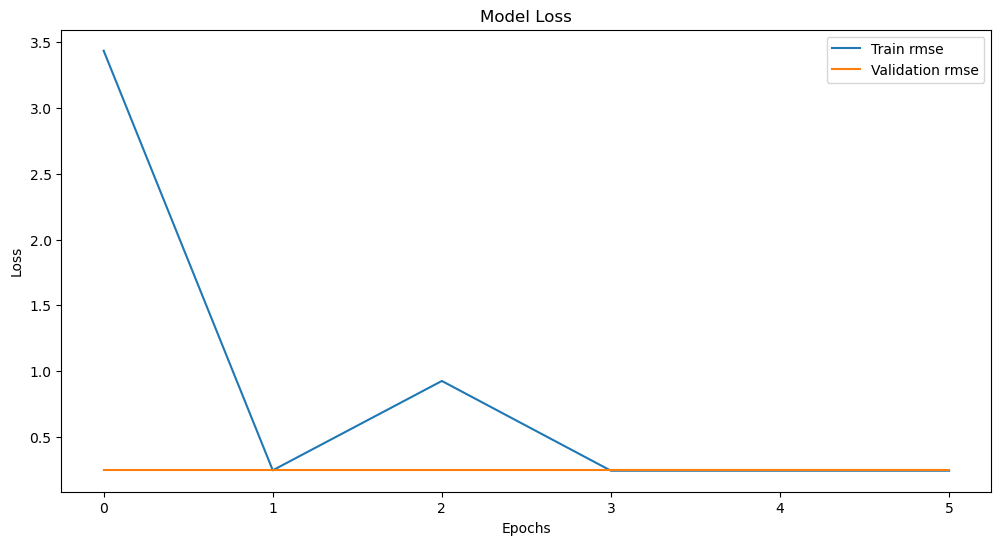

In [329]:
plt.figure(figsize=(12, 6))
plt.plot(hist.history['root_mean_squared_error'], label='Train rmse')
plt.plot(hist.history['val_root_mean_squared_error'], label='Validation rmse')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Inference

In [34]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
from tensorflow.keras.models import * 


In [35]:
def forecast_next_days(model, last_data, gt, use_gt=True, gt_every=30, use_dropout=False):
    predictions = []
    current_data = last_data
    data_received = []
    for i in range(len(gt)):
        next_pred = model(current_data.reshape(1, 30, current_data.shape[1]), training=use_dropout)
        
        x = next_pred[0]
        predictions.append(x)
        next = gt[i] if use_gt else x 
        if i % gt_every == 0 and use_gt and i > 0:
            current_data = gt[i-len(current_data):i]
            data_received.append(1)
        else: 
            current_data = np.append(current_data[1:], [next], axis=0)  # Update the input for the next prediction
            data_received.append(0)
    return np.array(predictions), np.array(data_received)

In [36]:
scaler = pkl.load(open('scaler.pkl', 'rb'))
scaled = pkl.load(open('scaled_test.pkl', 'rb'))
model = load_model('model_base.keras')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 31)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 31)             │         7,812 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,438 (91.56 KB)

 Trainable params: 7,812 (30.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,626 (61.04 KB)

In [80]:
n = 360
t = 0
print(scaled.shape)
predictions = scaled[t:t+n]
print(predictions.shape)
history = predictions[0:30]
ground_truth = predictions[30:]
print(ground_truth.shape)

(367, 31)
(360, 31)
(330, 31)


In [81]:
fcs = []
for i in range(0, 25):
    forecast, dr = forecast_next_days(model, history, ground_truth, True, use_dropout=True)
    fcs.append(forecast)

In [82]:
mean = fcs[0]
for i in range(1, len(fcs)):
    mean += fcs[i]
mean /= len(fcs)

std = np.square(fcs[0] - mean)
for i in range(1, len(fcs)):
    std += np.square(fcs[i] - mean)
std /= len(fcs)
std = np.sqrt(std)

In [83]:
forecast_inverse = scaler.inverse_transform(mean)
confidence_inverse = scaler.inverse_transform(std)
ground_truth = scaler.inverse_transform(ground_truth)

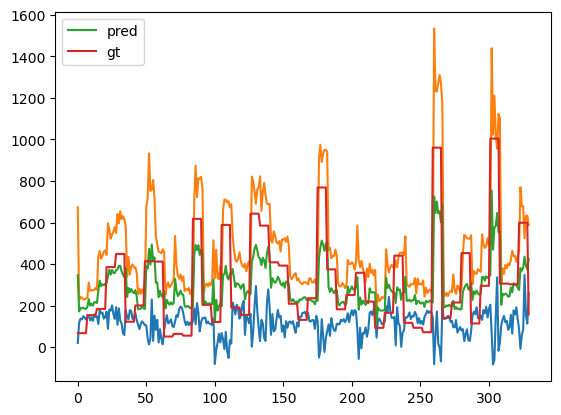

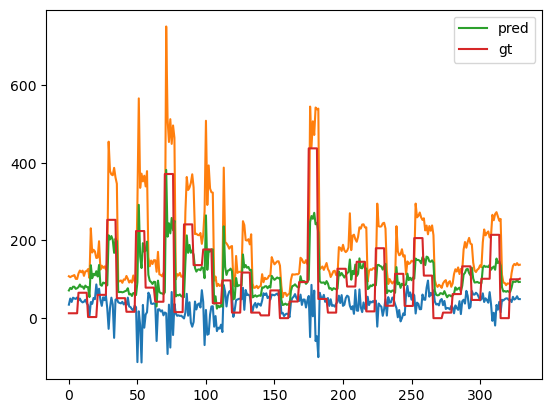

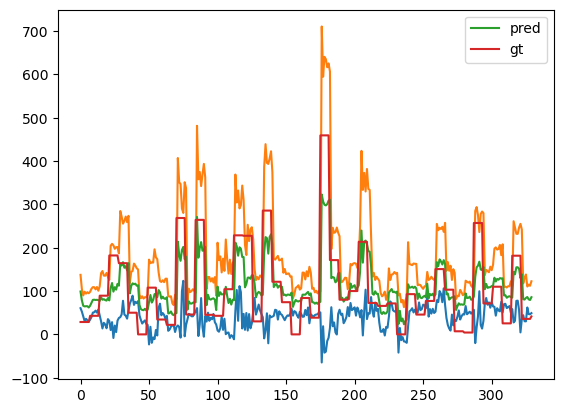

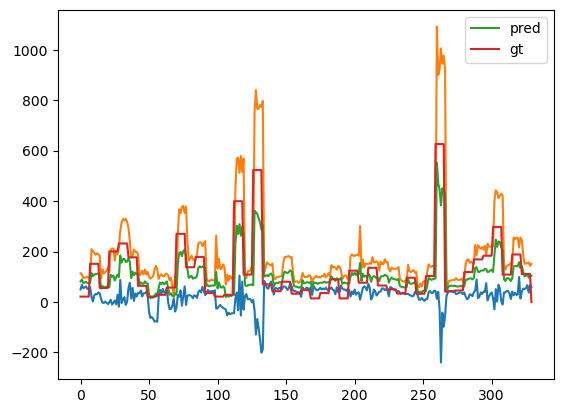

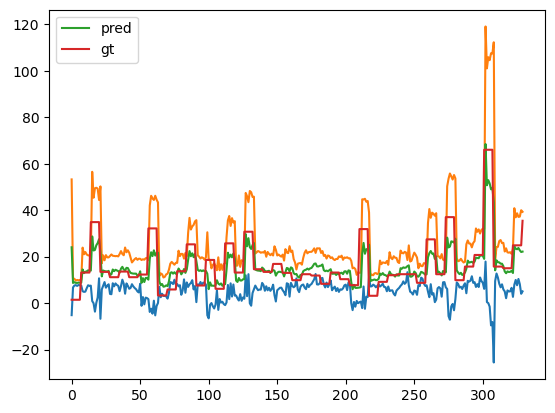

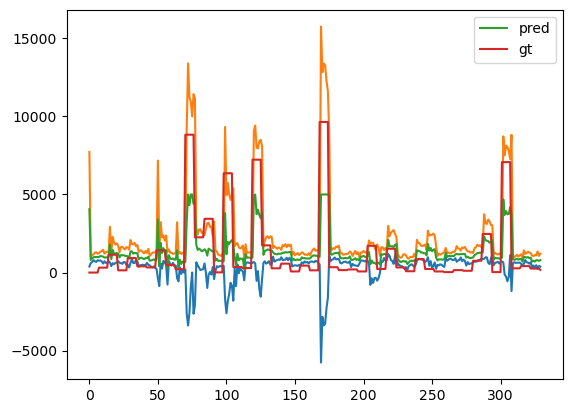

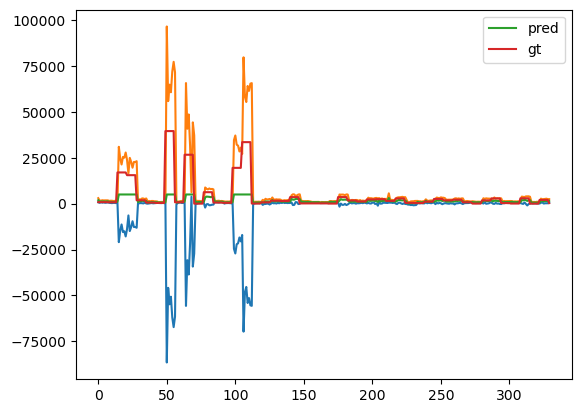

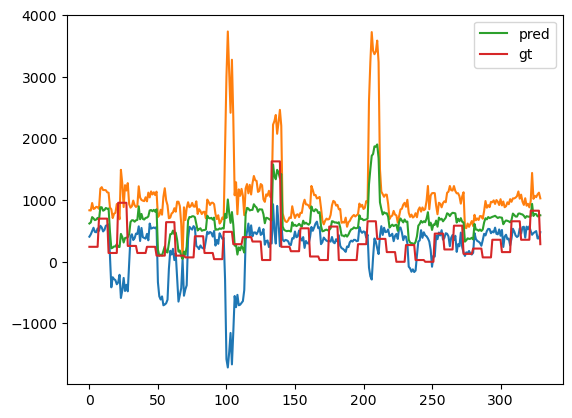

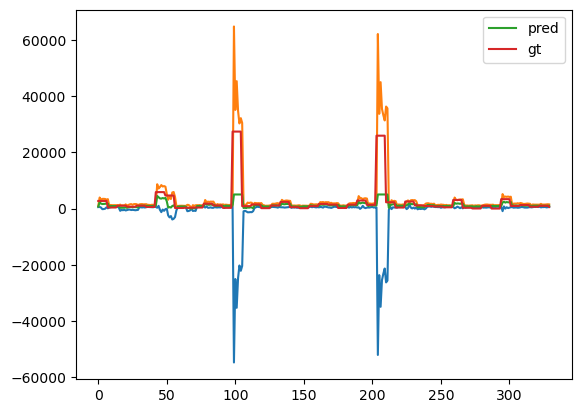

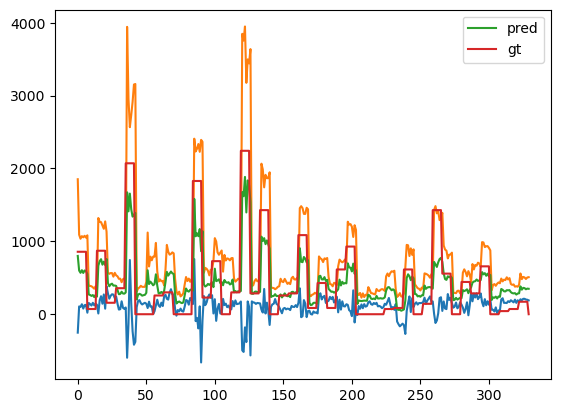

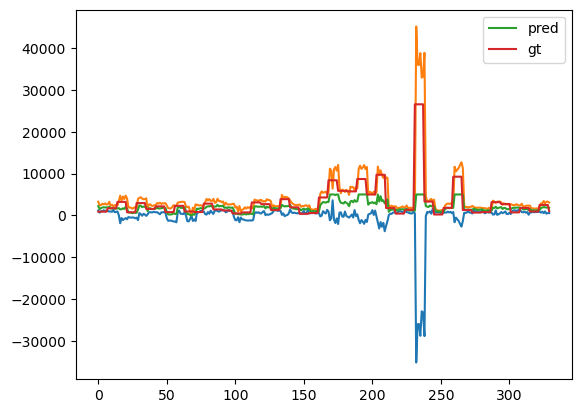

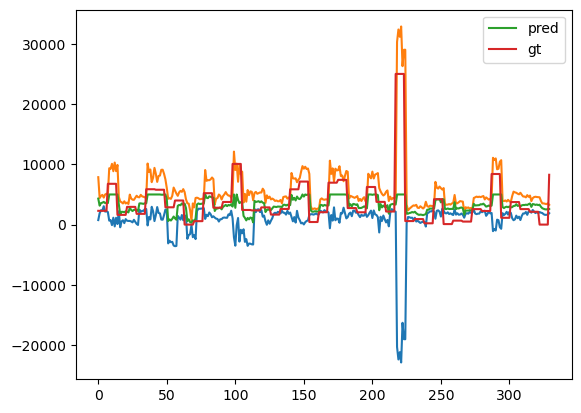

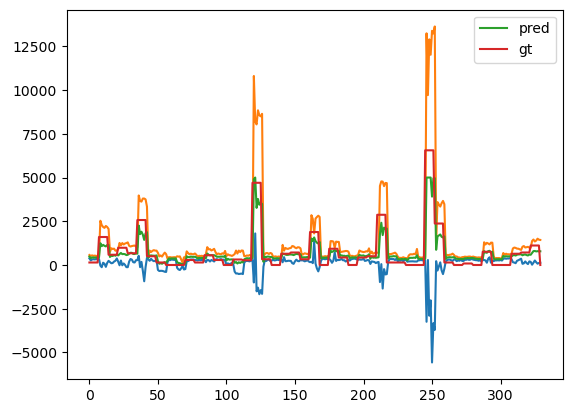

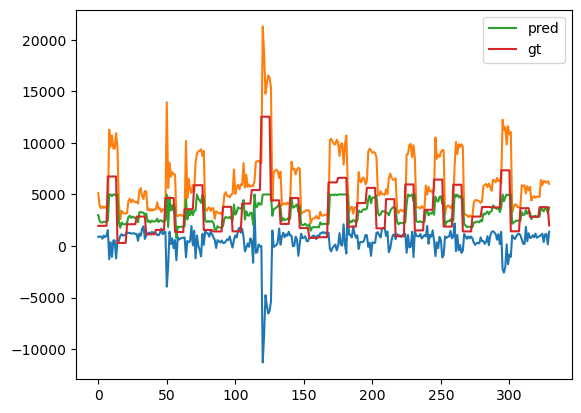

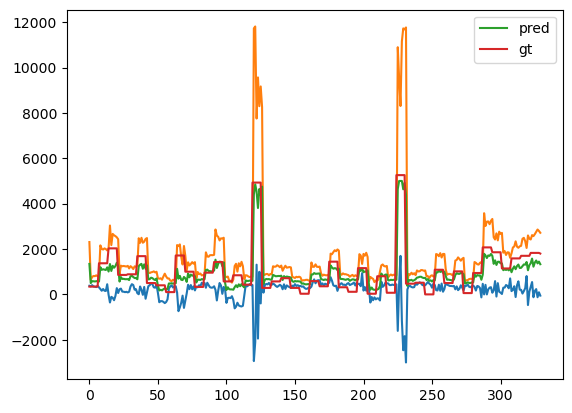

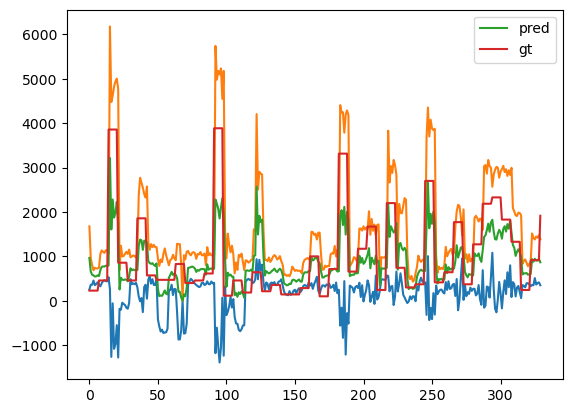

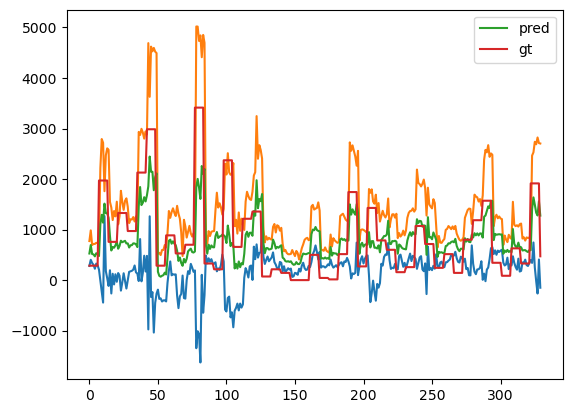

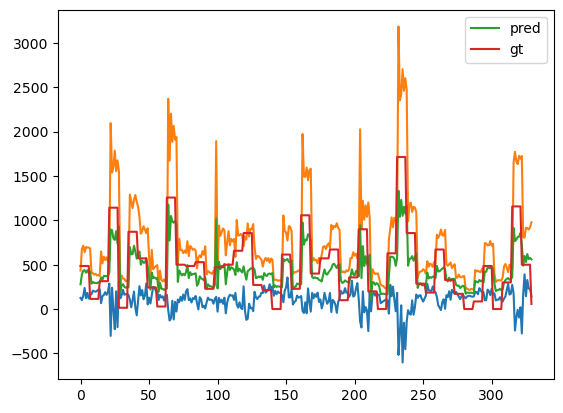

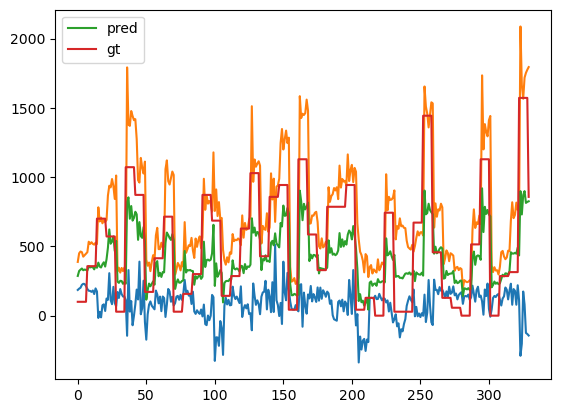

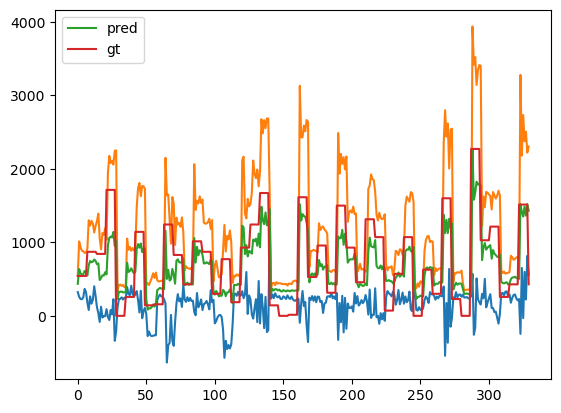

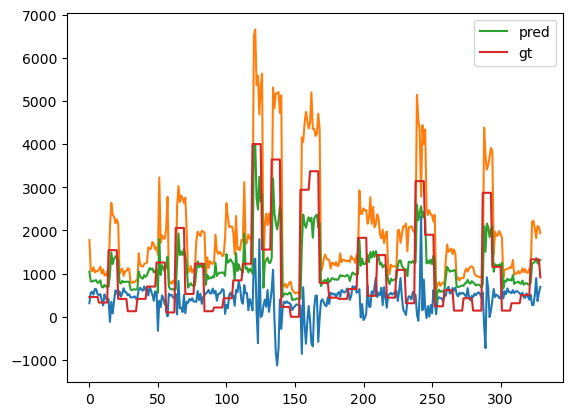

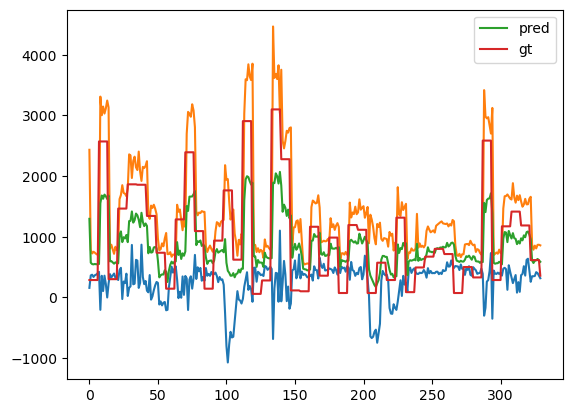

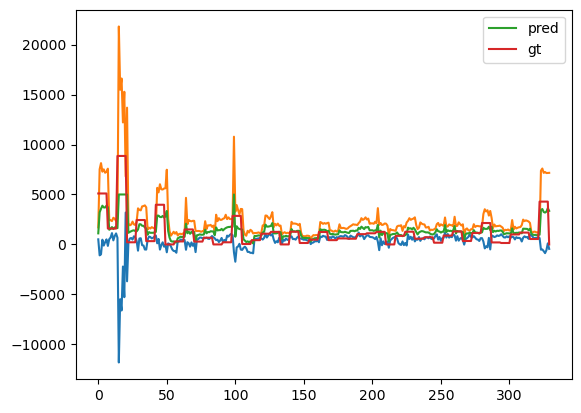

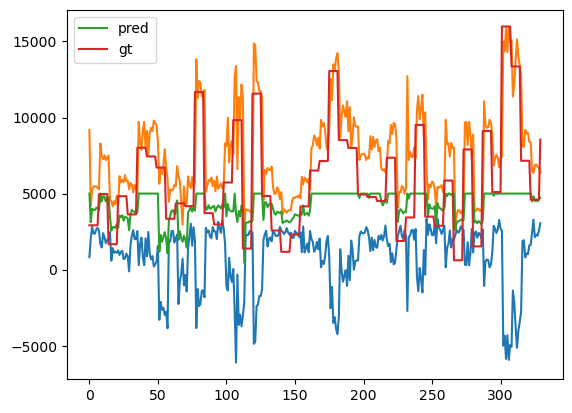

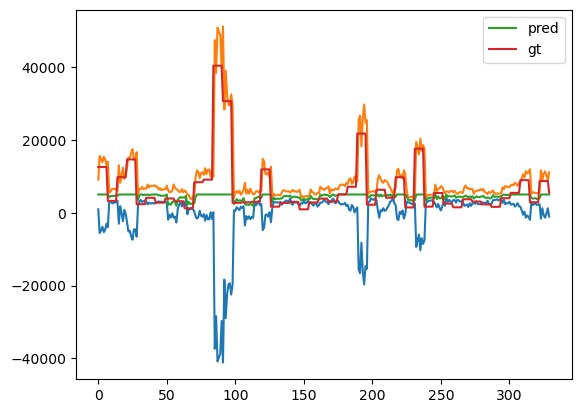

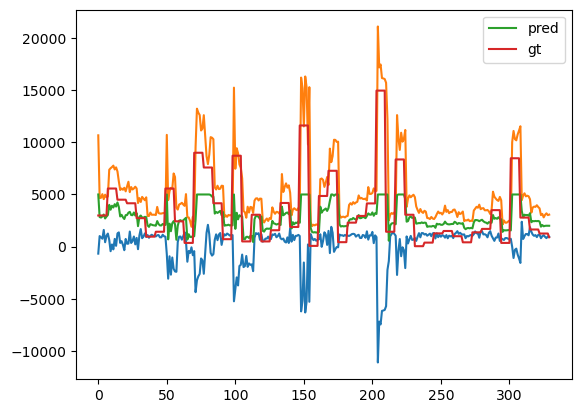

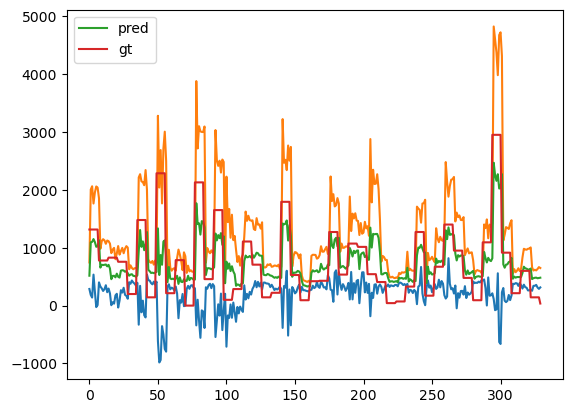

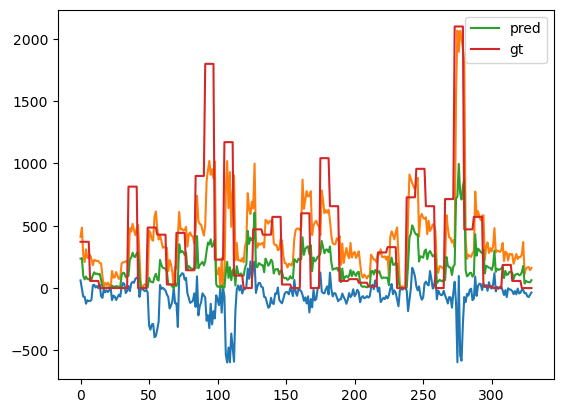

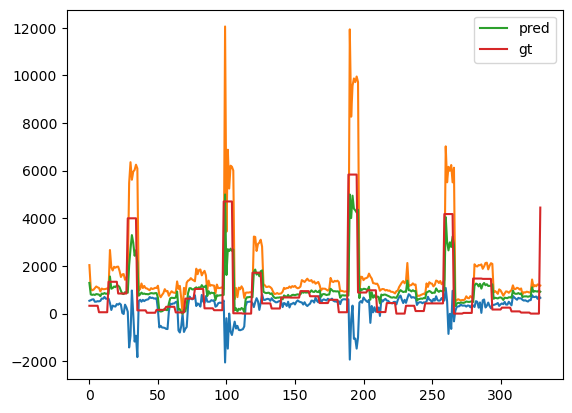

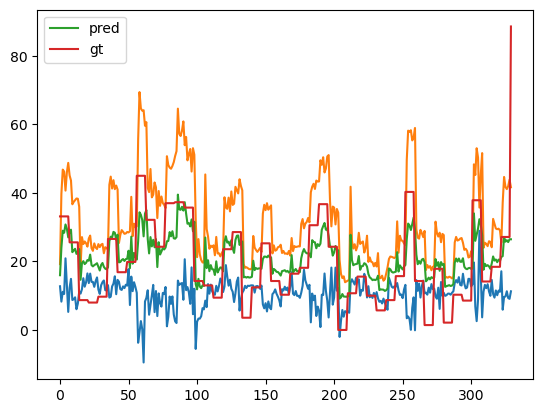

In [84]:
forecast_inverse[forecast_inverse > 5000] = 5000
for i in range(1, 31):
    
    plt.plot(forecast_inverse[:, i] - 3 * confidence_inverse[:, i])
    plt.plot(forecast_inverse[:, i] + 3 * confidence_inverse[:, i])

    plt.plot(forecast_inverse[:, i], label = 'pred')
    plt.plot(ground_truth[:, i], label = 'gt')
    plt.legend()
    
    plt.show()

In [68]:
n = 60
t = 0
print(scaled.shape)
predictions = scaled[t:t+n]
print(predictions.shape)
history = predictions[0:30]
ground_truth = predictions[30:]
print(ground_truth.shape)

(367, 31)
(60, 31)
(30, 31)


In [69]:
fcs = []
for i in range(0, 25):
    forecast, dr = forecast_next_days(model, history, ground_truth, False, use_dropout=True)
    fcs.append(forecast)

In [70]:
mean = fcs[0]
for i in range(1, len(fcs)):
    mean += fcs[i]
mean /= len(fcs)

std = np.square(fcs[0] - mean)
for i in range(1, len(fcs)):
    std += np.square(fcs[i] - mean)
std /= len(fcs)
std = np.sqrt(std)

In [71]:
forecast_inverse = scaler.inverse_transform(mean)
confidence_inverse = scaler.inverse_transform(std)
ground_truth = scaler.inverse_transform(ground_truth)

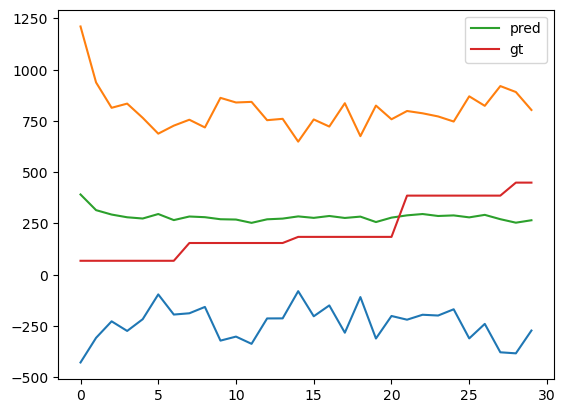

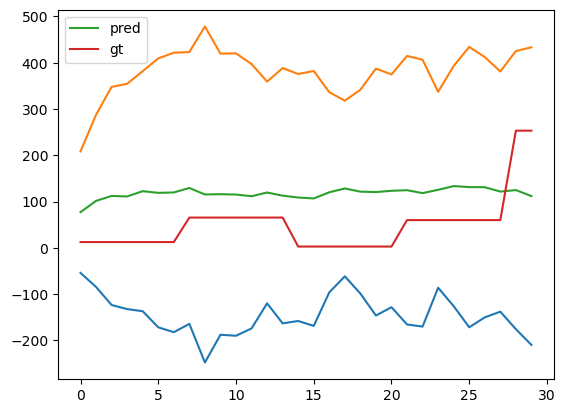

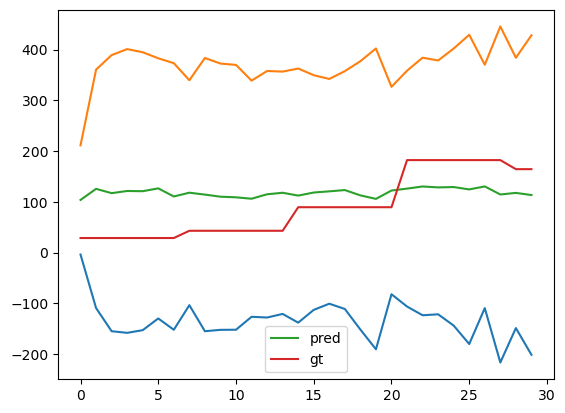

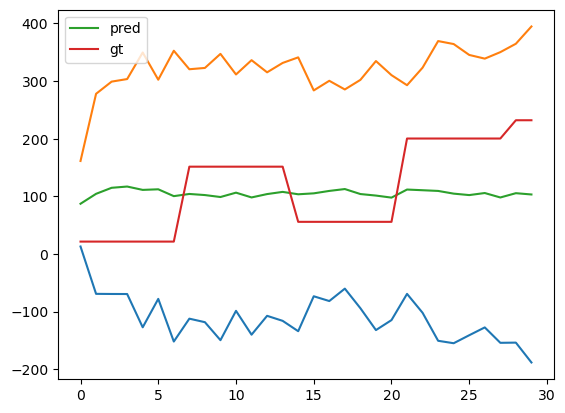

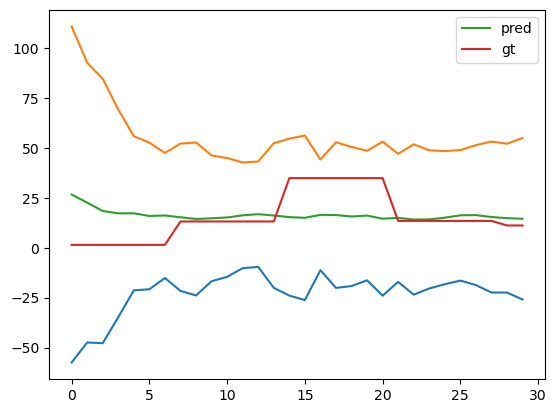

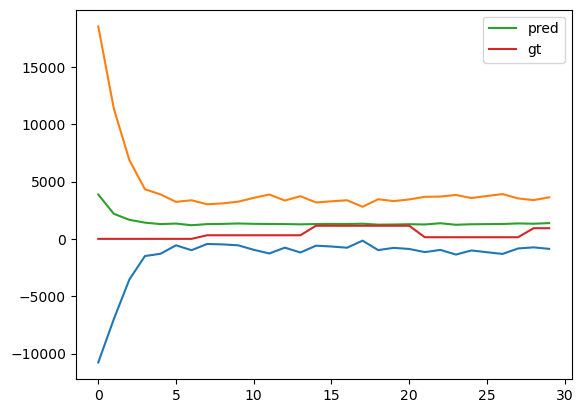

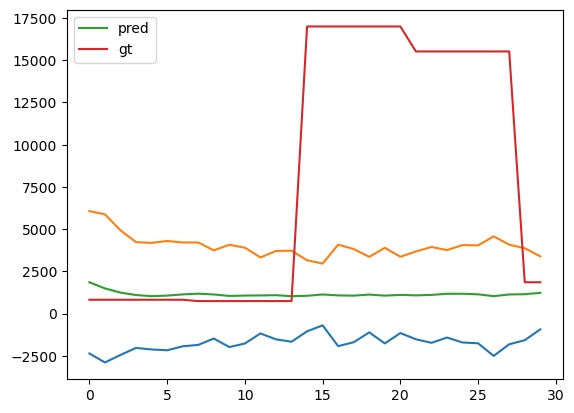

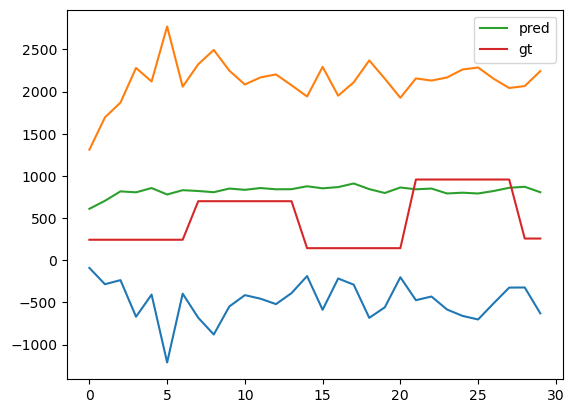

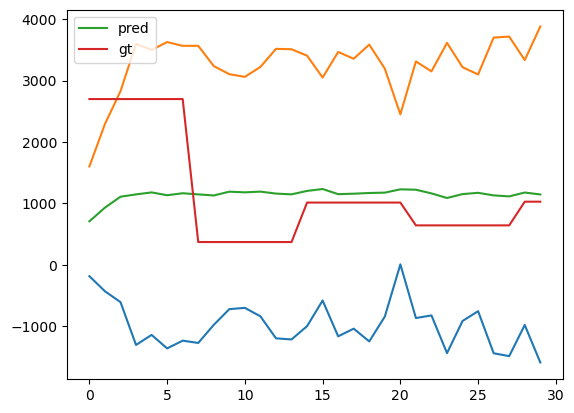

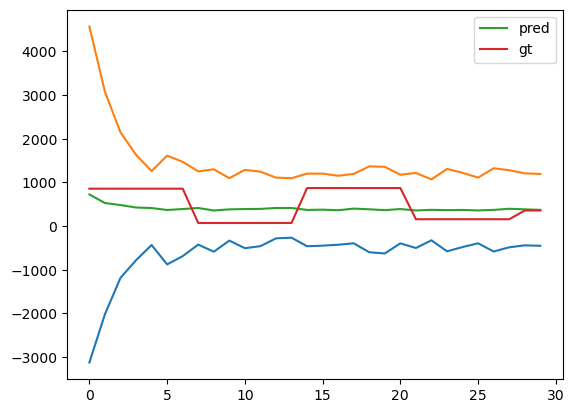

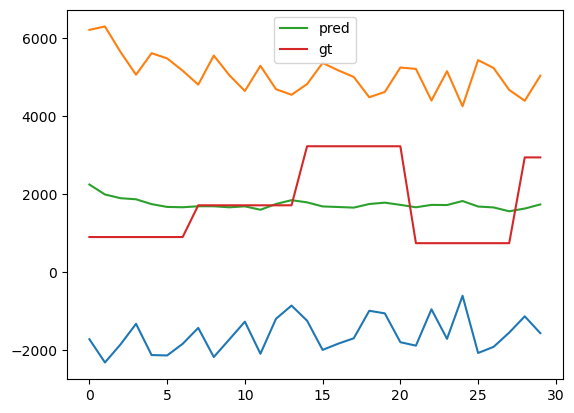

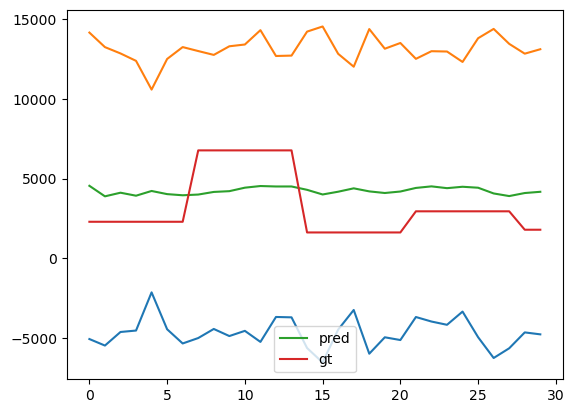

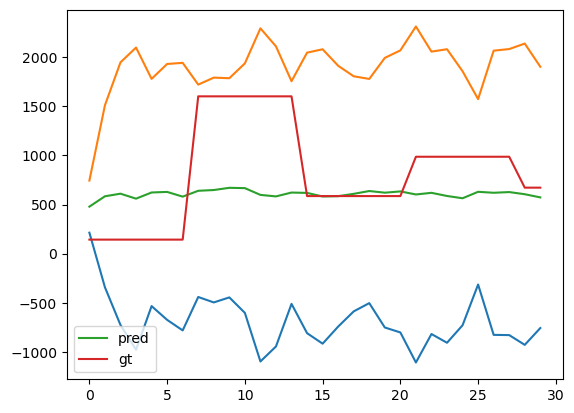

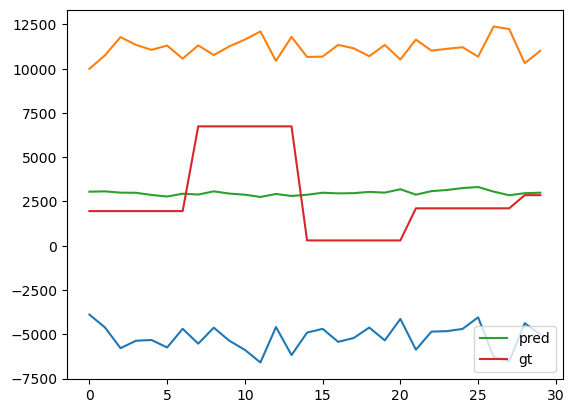

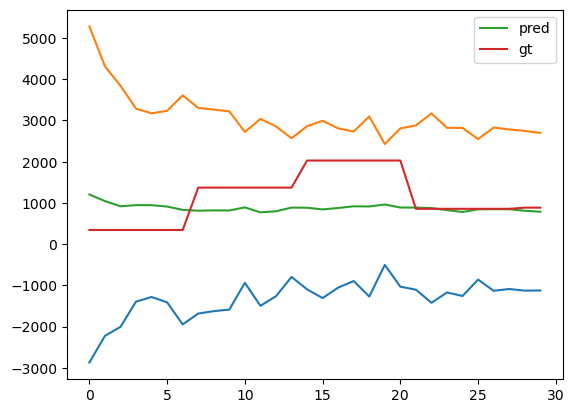

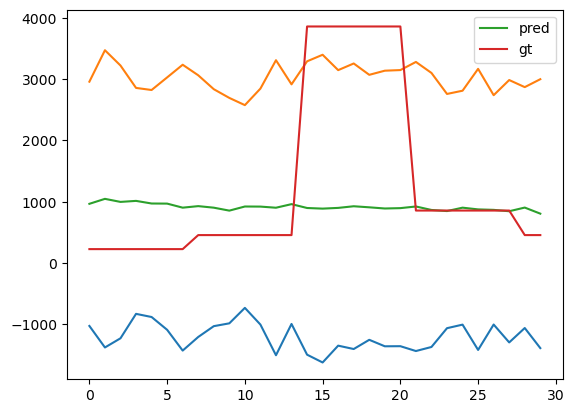

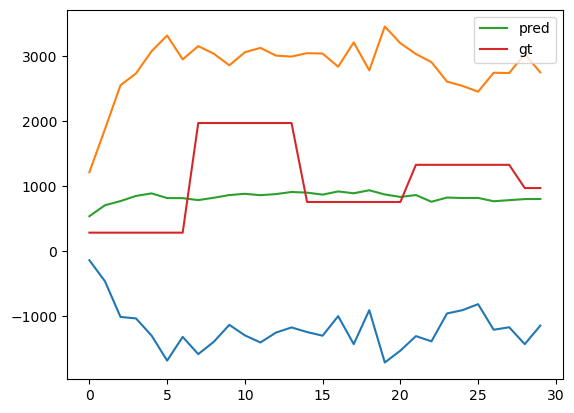

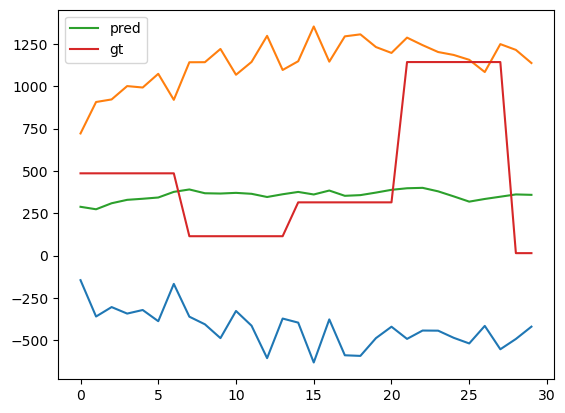

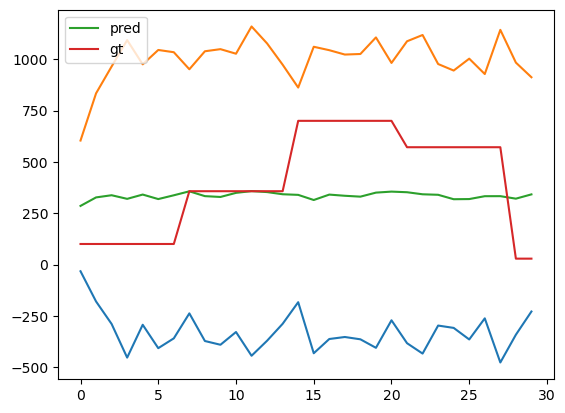

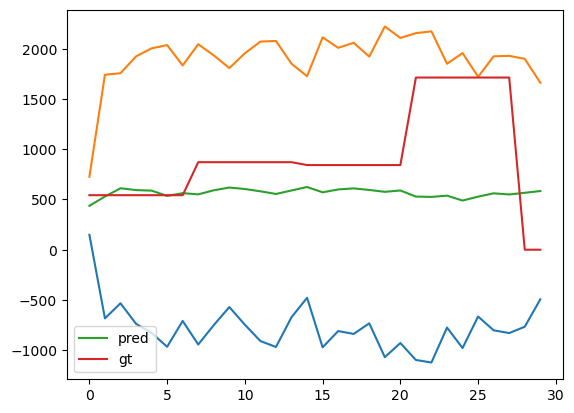

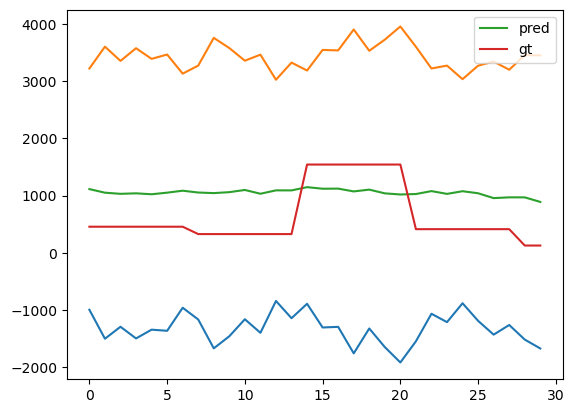

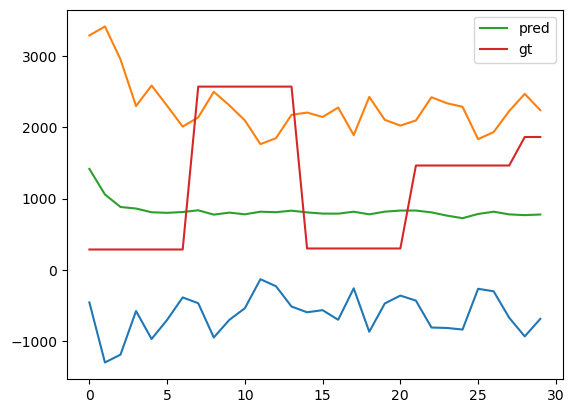

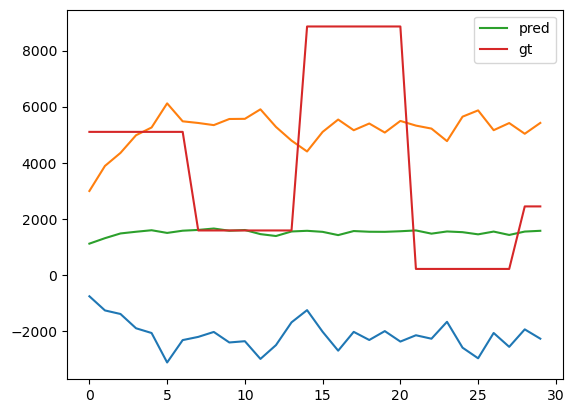

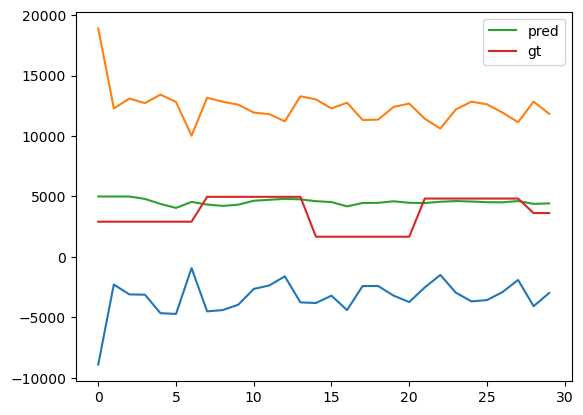

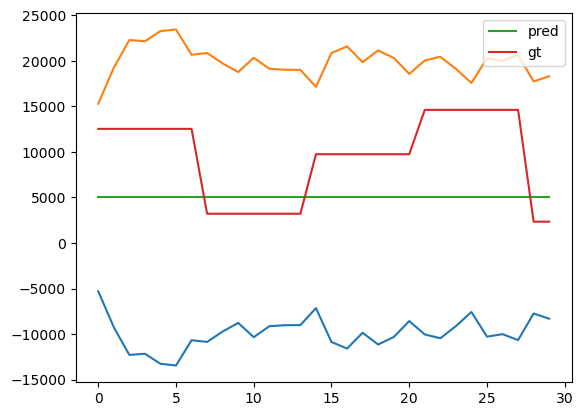

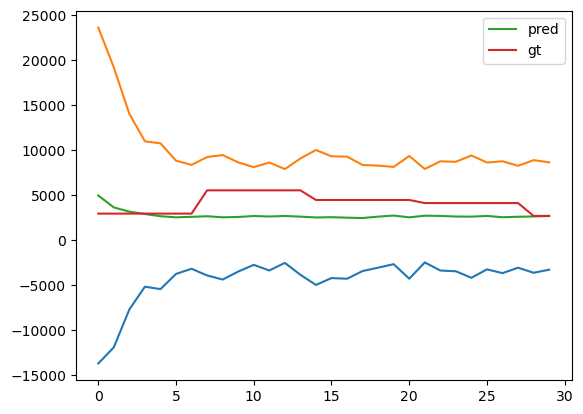

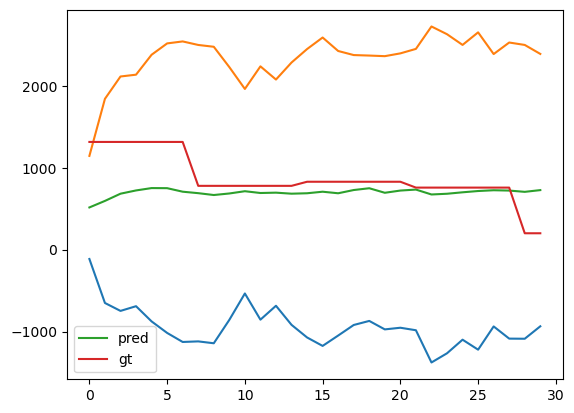

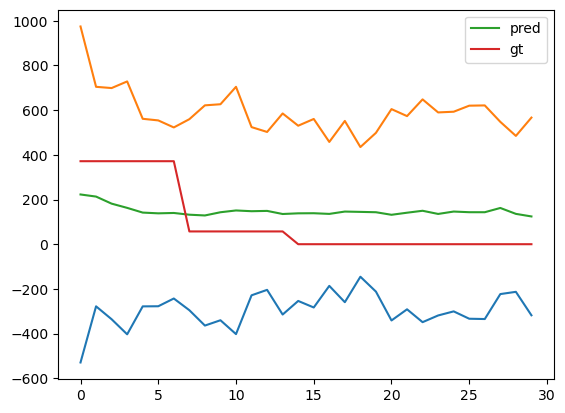

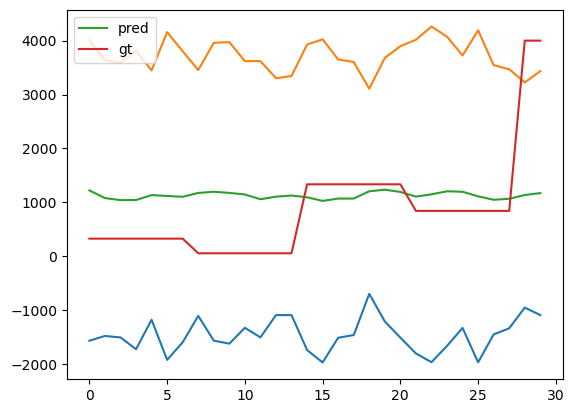

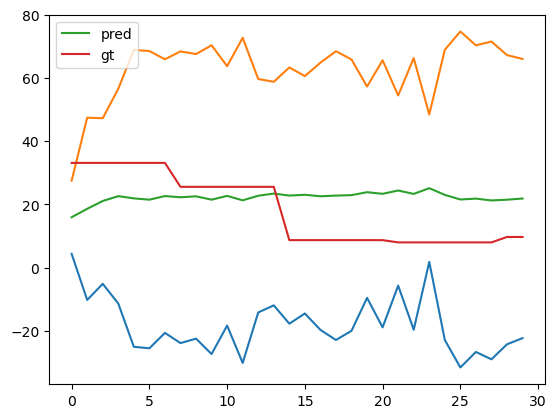

In [72]:
forecast_inverse[forecast_inverse > 5000] = 5000
for i in range(1, 31):
    plt.plot(forecast_inverse[:, i] - 10 * confidence_inverse[:, i])
    plt.plot(forecast_inverse[:, i] + 10 * confidence_inverse[:, i])

    plt.plot(forecast_inverse[:, i], label = 'pred')
    plt.plot(ground_truth[:, i], label = 'gt')
    plt.legend()
    plt.show()